# Slot Filling

In [43]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#change current working directory
%cd "/content/drive/Shareddrives/NLI"

/content/drive/Shareddrives/NLI


In [45]:
#Print path and content of the current directory
!pwd
!ls

/content/drive/Shareddrives/NLI
bert.ipynb  dataset.hf	logs  model  results  Slot_fitting.ipynb


In [46]:
!pip install transformers
!pip install seqeval
!pip install datasets

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertTokenizerFast, BertConfig, BertForTokenClassification
from seqeval.metrics import classification_report
from datasets import load_dataset

import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from tqdm import tqdm
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
#DATASET_FILEPATH = './events/attack.txt'
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05

In [49]:
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

In [50]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [51]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue

        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

In [52]:
def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

In [53]:
#dataset = load_dataset('multi_woz_v22')

from datasets import DatasetDict
dataset = DatasetDict.load_from_disk("dataset.hf")

train = preprocess_split(dataset, 'train')
val = preprocess_split(dataset, 'validation')
test = preprocess_split(dataset, 'test')

In [54]:
ignored_tags = []

In [55]:
def extract_token_bio_tags(dataset):
    utterances = [[]]
    count = 0

    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for utterance, speaker, dialogue_act, frames in zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames']):
            if speaker != 0:
                continue
            if 'other' in process_service_list(frames['service']):
                continue

            span_info = dialogue_act['span_info']
            act_slot_names = span_info['act_slot_name']
            act_slot_values = span_info['act_slot_value']
            span_starts = span_info['span_start']
            span_ends = span_info['span_end']
            slots = {slot_name : {'start': start, 'end': end} for slot_name, start, end in zip(act_slot_names, span_starts, span_ends)}

            #Preprocess

            last_tag = 0
            utterances.append([])
            for slot_name in slots:
                slot_start, slot_end = slots[slot_name]['start'], slots[slot_name]['end']
                tokens = re.sub("[^a-zA-Z0-9]", " ", utterance[slot_start:slot_end]).lower().split()
                for word in re.sub("[^a-zA-Z0-9]", " ", utterance[last_tag:slot_start]).lower().split():
                  utterances[count].append((word, "O"))

                for j, token in enumerate(tokens):
                    bio_type = 'B-' if j == 0 else 'I-'
                    if bio_type + slot_name not in ignored_tags:
                        utterances[count].append((token, bio_type + slot_name))
                last_tag = slot_end

            for word in re.sub("[^a-zA-Z0-9]", " ", utterance[last_tag:]).lower().split():
                  utterances[count].append((word, "O"))
            count = count+1


    return utterances

In [56]:
# building X, y
train_word_tag = extract_token_bio_tags(train)
valid_word_tag = extract_token_bio_tags(val)
test_word_tag = extract_token_bio_tags(test)

print("\nSize train_sentencs: ", len(train_word_tag))
print("Size valid_sentences: ", len(valid_word_tag))
print("Size test_sentences: ", len(test_word_tag))



100%|██████████| 745/745 [00:00<00:00, 1647.29it/s]


Size train_sentencs:  23542
Size valid_sentences:  2668
Size test_sentences:  2619


In [57]:
from collections import Counter
print("Number of utterances:", len(train_word_tag))
print("Frequency")
counter = sorted(Counter([tag for sentence in train_word_tag for _, tag in sentence]).items(), key=lambda x: x[1], reverse=True)
for tag, val in counter:
    print(f'{tag:20} {val}')

print("\nEach tag appears in number of documents")
docs = {}
for i, sentence in enumerate(train_word_tag):
    for _, tag in sentence:
        if tag not in docs:
            docs[(i, tag)] = 1
        else:
            docs[(i, tag)] += 1
counter = Counter([tag for i, tag in docs])
for tag in counter:
  print(f'{tag:20} {counter[tag]}')


Number of utterances: 23542
Frequency
O                    255910
B-area               4324
B-pricerange         4301
B-food               3805
B-bookpeople         3223
B-bookday            3208
B-bookstay           2306
I-name               2277
B-type               2150
B-stars              1841
B-name               1787
I-booktime           1574
B-booktime           1561
I-area               824
I-food               641
I-pricerange         442
I-bookpeople         226
I-bookday            150
I-type               59
I-bookstay           2

Each tag appears in number of documents
O                    23525
B-area               4324
B-pricerange         4301
B-type               2150
B-bookstay           2306
B-bookpeople         3223
B-bookday            3208
I-pricerange         219
B-name               1787
I-name               1406
B-food               3805
B-booktime           1561
I-booktime           1545
I-food               492
B-stars              1841
I-area              

In [58]:
all_words = set([word for sentence in train_word_tag for word, _ in sentence])

max_seq_len = max([len(x) for x in train_word_tag])
print("max_seq_leng:", max_seq_len)

n_words = len(all_words)
print("Number of words:", n_words)
print("Words: ", all_words)

# As the BertTokenizer uses wordpiece, the number of tokens is higher than the actual word count, so we set the max_seq_len to 128
max_seq_len = 128

max_seq_leng: 37
Number of words: 2289
Words:  {'busy', 'down', 'event', 'moroccan', 'beach', 'aylesbray', 'dood', 'through', 'accomadation', 'third', 'glad', 'alone', 'sooner', 'lkle', 'didn', 'rated', 'thanh', 'reastaurant', 'researching', 'aims', 'preferrably', 'punter', 'nirala', 'fer', 'doubt', 'table', 'sitar', 'placed', 'carolina', 'margherita', 'apreciate', 'st', 'recap', 'meal', 'public', 'indifferent', 'ourselves', 'pm', 'wandered', 'short', 'outside', 'mistaken', 'awhile', 'wednesday', 'need', 'moderite', 'greek', 'anyplace', 'associated', 'huh', 'somwehere', 'such', 'irish', '125', '30', 'pay', 'minimum', 'distracted', 'basic', 'surprise', 've', 'aside', 'guesthoise', 'erania', 'place', 'hotel', 'read', 'oops', 'online', 'english', 'crazy', 'response', 'fit', 'sent', 'now', 'worries', 'besides', 'category', 'traveller', 'yeas', 'waiting', 'severing', 'addresses', 'siagon', 'play', 'fix', 'both', 'seat', 'brilliant', 'format', 'original', 'corkhouse', '451', 'yeah', 'honest'

In [59]:
all_tags = set([tag for sentence in train_word_tag for _, tag in sentence])
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

Number of tags: 20
Tags: {'B-area', 'I-bookpeople', 'I-food', 'B-type', 'B-pricerange', 'B-bookpeople', 'I-area', 'B-stars', 'B-name', 'B-booktime', 'I-name', 'I-bookday', 'O', 'B-bookstay', 'I-pricerange', 'B-food', 'I-bookstay', 'I-type', 'I-booktime', 'B-bookday'}


In [60]:
tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

In [61]:
tag2index

{'B-area': 0,
 'I-bookpeople': 1,
 'I-food': 2,
 'B-type': 3,
 'B-pricerange': 4,
 'B-bookpeople': 5,
 'I-area': 6,
 'B-stars': 7,
 'B-name': 8,
 'B-booktime': 9,
 'I-name': 10,
 'I-bookday': 11,
 'O': 12,
 'B-bookstay': 13,
 'I-pricerange': 14,
 'B-food': 15,
 'I-bookstay': 16,
 'I-type': 17,
 'I-booktime': 18,
 'B-bookday': 19}

In [62]:
index2tag

{0: 'B-area',
 1: 'I-bookpeople',
 2: 'I-food',
 3: 'B-type',
 4: 'B-pricerange',
 5: 'B-bookpeople',
 6: 'I-area',
 7: 'B-stars',
 8: 'B-name',
 9: 'B-booktime',
 10: 'I-name',
 11: 'I-bookday',
 12: 'O',
 13: 'B-bookstay',
 14: 'I-pricerange',
 15: 'B-food',
 16: 'I-bookstay',
 17: 'I-type',
 18: 'I-booktime',
 19: 'B-bookday'}

In [63]:
# Initialize Bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained(TRANSFORMER_MODEL_NAME)


In [64]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.X[index]
        word_labels = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2index[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

In [65]:
X_train = [[word for word, _ in sentence] for sentence in train_word_tag]
y_train = [[tag for _, tag in sentence] for sentence in train_word_tag]

X_valid = [[word for word, _ in sentence] for sentence in valid_word_tag]
y_valid = [[tag for _, tag in sentence] for sentence in valid_word_tag]

X_test = [[word for word, _ in sentence] for sentence in test_word_tag]
y_test = [[tag for _, tag in sentence] for sentence in test_word_tag]

training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

In [66]:
training_set[0]

{'input_ids': tensor([  101,  1045,  2342,  1037,  2173,  2000, 11586,  2063,  1999,  1996,
          2415,  2008,  2015,  6450,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [67]:
index = 1
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[index]["input_ids"]), training_set[index]["labels"]):
  print(f'{token:10} {label:3} ')

[CLS]      -100 
any         12 
sort        12 
of          12 
food        12 
would       12 
be          12 
fine        12 
as          12 
long        12 
as          12 
it          12 
is          12 
a           12 
bit         12 
expensive   12 
could       12 
i           12 
get         12 
the         12 
phone       12 
number      12 
for         12 
your        12 
recommendation  12 
[SEP]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 
[PAD]      -100 


In [68]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [69]:
model = BertForTokenClassification.from_pretrained(TRANSFORMER_MODEL_NAME, num_labels=len(tag2index))
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [70]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(3.1021, device='cuda:0', grad_fn=<NllLossBackward0>)

In [71]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 20])

In [72]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [73]:
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [74]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)

            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")

            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=10
            )

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    _, _ , val_loss, val_acc = valid(model, validation_loader)

    return epoch_loss, tr_accuracy, val_loss, val_acc


In [75]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)


Epoch 4: 100%|██████████| 2943/2943 [09:22<00:00,  5.23it/s, accuracy=0.985, loss=0.0411]


<function matplotlib.pyplot.show(close=None, block=None)>

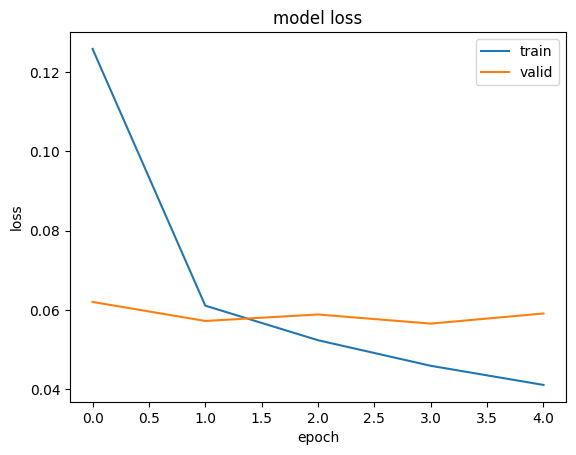

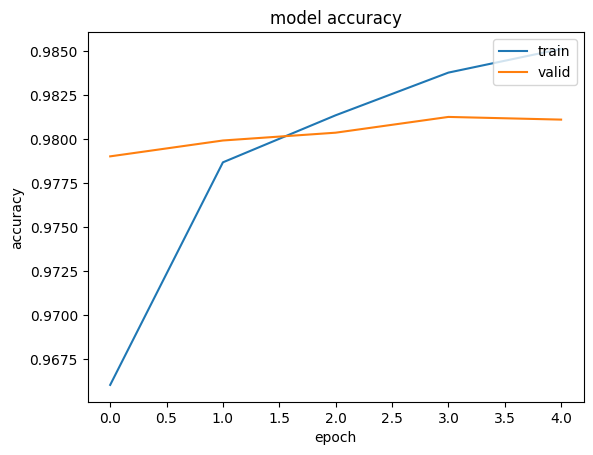

In [76]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [80]:
labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")

Validation : loss 0.05 accuracy 0.98


In [81]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

# for source, pred in zip(labels, predictions):
#   print(f'{source:20} {pred}')




              precision    recall  f1-score   support

        area       0.91      0.96      0.93       449
     bookday       0.91      0.99      0.95       367
  bookpeople       0.91      0.98      0.94       380
    bookstay       0.95      0.97      0.96       259
    booktime       0.94      0.98      0.96       210
        food       0.96      0.94      0.95       379
        name       0.85      0.91      0.88       278
  pricerange       0.93      0.97      0.94       486
       stars       0.96      0.98      0.97       190
        type       0.79      0.76      0.78       243

   micro avg       0.91      0.95      0.93      3241
   macro avg       0.91      0.94      0.93      3241
weighted avg       0.91      0.95      0.93      3241



In [82]:
model.save_pretrained('./model/task2')